20195234 임지운
영상처리와 딥러닝 과제 5

In [ ]:
!pip install torch torchvision

In [ ]:
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.init as init
import torch.nn.functional as F
import torchvision.datasets as dset
import torchvision.transforms as transforms
from torch.utils.data import DataLoader
from torch.autograd import Variable
from torchvision.utils import save_image
import matplotlib.pyplot as plt

In [ ]:
#기초 파라미터 설정
batch_size = 8
learning_rate = 0.0002
num_epoch = 20

## 과제 5

### 1 Custom dataset class 구현

In [ ]:
from sklearn.model_selection import train_test_split
import os
from glob import glob

def get_data():
    file_path_Y = './data/*-2.png'    #내가 원하는 출력 결과
    file_path_X = './data/*-1.png'    #입력 사진

    #가능한 모든 파일 경로를 읽어온다.
    file_path_Y = glob(file_path_Y)
    file_path_X = glob(file_path_X)

    #서로 대응되는 데이터셋이기 때문에 정렬을 해준다.
    file_path_Y.sort()
    file_path_X.sort()

    #데이터를 분할한다.
    train_path_x, test_path_x, train_path_y, test_path_y = train_test_split(file_path_X, file_path_Y, test_size=0.15, random_state=2)

    return train_path_x, test_path_x, train_path_y, test_path_y

In [ ]:
train_path_x, test_path_x, train_path_y, test_path_y = get_data()

In [ ]:
from torch.utils.data import Dataset, DataLoader
from PIL import Image

class CustomDataset():
    def __init__(self, path_input, path_target, transform= transforms.ToTensor()):
        self.path_input = path_input
        self.path_target = path_target
        self.transform = transform

    def __len__(self):
        return len(self.path_input)

    def __getitem__(self, idx):
        image_input = Image.open(self.path_input[idx])
        image_target = Image.open(self.path_target[idx])

        # 이미지 전처리 및 텐서로 변환
        if self.transform:
            image_input = self.transform(image_input)
            image_target = self.transform(image_target)

        return (image_input, image_target)

# CustomDataset 생성
dataset = CustomDataset(train_path_x, train_path_y, transform = transforms.ToTensor())

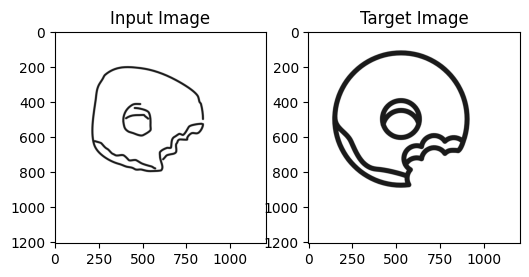

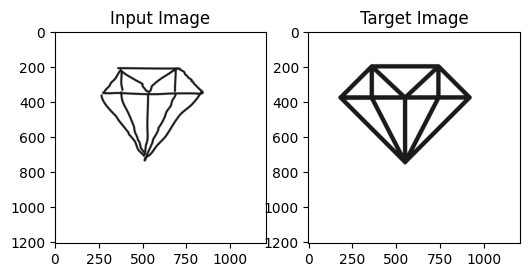

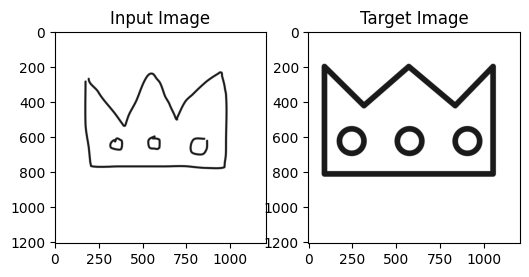

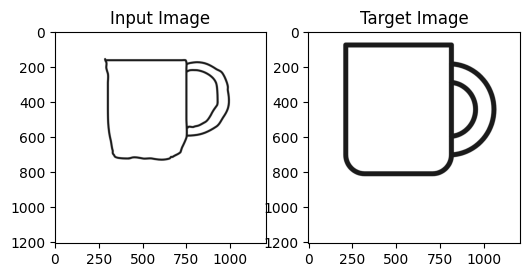

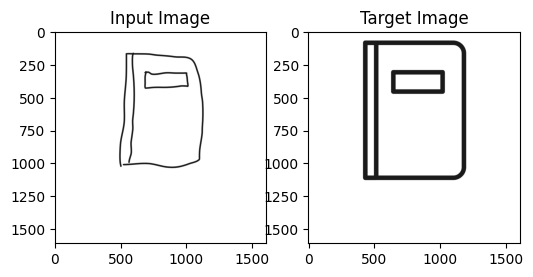

In [ ]:
#데이터가 제대로 들어갔는지 확인하기 위해 출력해본다.
import matplotlib.pyplot as plt

for i in range(5,10):
    input_image = dataset[i][0].permute(1, 2, 0).numpy()
    target_image = dataset[i][1].permute(1, 2, 0).numpy()

    plt.figure(figsize=(6, 3))

    plt.subplot(1, 2, 1)
    plt.imshow(input_image, cmap='gray')
    plt.title("Input Image")

    plt.subplot(1, 2, 2)
    plt.imshow(target_image, cmap='gray')
    plt.title("Target Image")

    plt.show()

### 2 데이터의 증강 구현

In [ ]:
#데이터를 좌우 반전후 상하 반전 시킨 것이다.
transform1 = transforms.Compose([
    transforms.Resize(256),
    transforms.Grayscale(),
    transforms.RandomHorizontalFlip(p=1.0), #데이터를 좌우 반전 시킴
    transforms.RandomVerticalFlip(p=1.0),  #데이터를 상하 반전 시킴
    transforms.ToTensor()
])

#데이터를 좌우반전만 시킨 것이다.
transform2 = transforms.Compose([
    transforms.Resize(256),
    transforms.Grayscale(),
    transforms.RandomHorizontalFlip(p=1.0), #데이터를 좌우 반전 시킴
    transforms.ToTensor()
])

#데이터를 상하 반전 시킨 것이다.
transform3 = transforms.Compose([
    transforms.Resize(256),
    transforms.Grayscale(),
    transforms.RandomVerticalFlip(p=1.0),  #데이터를 상하 반전 시킴
    transforms.ToTensor()
])

In [ ]:
#기존 transform
transform = transforms.Compose([
    transforms.Resize(512),  # 이미지 크기를 512*512로 변경
    transforms.Grayscale(),       # 그레이스케일로 변환(이미 흑백이긴 하다.)
    transforms.ToTensor()        # 텐서로 변환
])

In [ ]:
train_dataset1 = CustomDataset(train_path_x, train_path_y, transform = transform)
train_dataset2 = CustomDataset(train_path_x, train_path_y, transform = transform1)
train_dataset3 = CustomDataset(train_path_x, train_path_y, transform = transform2)
train_dataset4 = CustomDataset(train_path_x, train_path_y, transform = transform3)
test_dataset = CustomDataset(test_path_x, test_path_y, transform = transform)

In [ ]:
#해당 코드를 사용하면 증감을 적용한 데이터를 합칠 수 있다.
from torch.utils.data import ConcatDataset
train_dataset = [train_dataset1, train_dataset2, train_dataset3, train_dataset4]
concatenated_dataset = ConcatDataset(train_dataset)

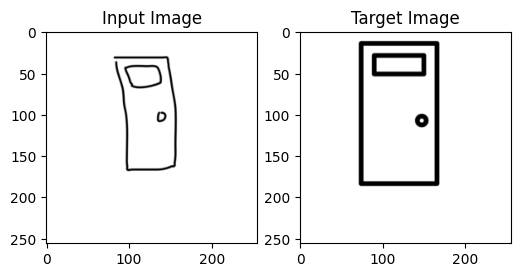

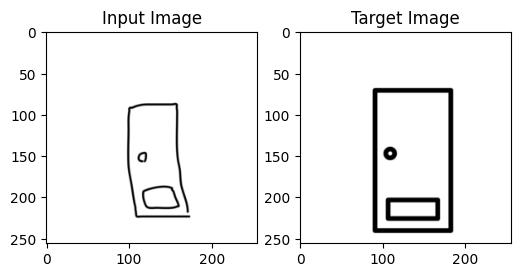

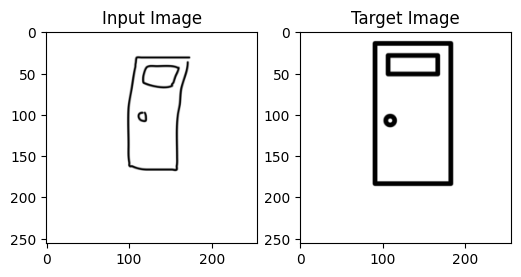

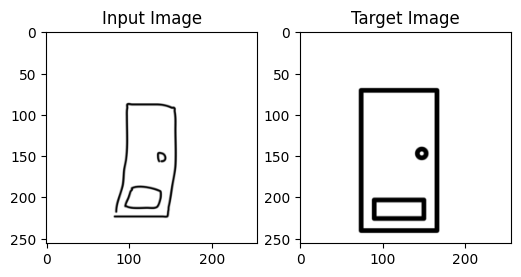

In [ ]:
#증강이 제대로 되었는지 확인해보자!
import matplotlib.pyplot as plt

for i in range(4):
    input_image = train_dataset[i][1][0].permute(1, 2, 0).numpy()
    target_image = train_dataset[i][1][1].permute(1, 2, 0).numpy()

    plt.figure(figsize=(6, 3))

    plt.subplot(1, 2, 1)
    plt.imshow(input_image, cmap='gray')
    plt.title("Input Image")

    plt.subplot(1, 2, 2)
    plt.imshow(target_image, cmap='gray')
    plt.title("Target Image")

    plt.show()

In [ ]:
# DataLoader 생성
train_loader = torch.utils.data.DataLoader(concatenated_dataset,batch_size=batch_size, shuffle=True,num_workers=2,drop_last=True)
test_loader = torch.utils.data.DataLoader(test_dataset,batch_size=batch_size, shuffle=False,num_workers=2,drop_last=True)

## 4. Model & Optimizer
### 1) Model

In [ ]:
class Autoencoder(nn.Module):
    def __init__(self):
        super(Autoencoder, self).__init__()
        # 인코더
        self.encoder = nn.Sequential(
            nn.Conv2d(1, 16, 3, stride=1, padding=1),  # 256x256x1 -> 256x256x16
            nn.ReLU(),
            nn.BatchNorm2d(16),                        # 정규화 과정
            nn.MaxPool2d(2, 2),                        # 256x256x16 -> 128x128x16
            nn.Conv2d(16, 32, 3, stride=1, padding=1), # 128x128x16 -> 128x128x32
            nn.ReLU(),
            nn.BatchNorm2d(32),                        # 정규화 과정
            nn.MaxPool2d(2, 2),                        # 128x128x32 -> 64x64x32
            nn.Conv2d(32, 64, 3, stride=1, padding=1), # 64x64x32 -> 64x64x64
            nn.ReLU(),
            nn.BatchNorm2d(64),                        # 정규화 과정
            nn.MaxPool2d(2, 2)                         # 64x64x64 -> 32x32x64
        )

        # 디코더
        self.decoder = nn.Sequential(
            nn.ConvTranspose2d(64, 32, 2, stride=2),   # 32x32x64 -> 64x64x32
            nn.ReLU(),
            nn.BatchNorm2d(32),                        # 정규화 과정
            nn.ConvTranspose2d(32, 16, 2, stride=2),   # 64x64x32 -> 128x128x16
            nn.ReLU(),
            nn.BatchNorm2d(16),                        # 정규화 과정
            nn.ConvTranspose2d(16, 8, 2, stride=2),    # 128x128x16 -> 256x256x8
            nn.ReLU(),
            nn.Conv2d(8, 1, 3, stride=1, padding=1),   # 256x256x8 -> 256x256x1
            nn.ReLU()
        )

    def forward(self, x):
        x = self.encoder(x)
        x = self.decoder(x)
        return x

### 2) Loss func & Optimizer

In [ ]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)

# 모델, 손실 함수 및 최적화기 초기화
model = Autoencoder().to(device)
loss_func = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

cuda:0


### 데이터 로더에 데이터가 제대로 들어갔는지 확인을 위한 코드들이다.

In [ ]:
for j, [image, target] in enumerate(train_loader):
  print(j, image.shape, target.shape)

0 torch.Size([8, 1, 256, 256]) torch.Size([8, 1, 256, 256])
1 torch.Size([8, 1, 256, 256]) torch.Size([8, 1, 256, 256])
2 torch.Size([8, 1, 256, 256]) torch.Size([8, 1, 256, 256])
3 torch.Size([8, 1, 256, 256]) torch.Size([8, 1, 256, 256])
4 torch.Size([8, 1, 256, 256]) torch.Size([8, 1, 256, 256])
5 torch.Size([8, 1, 256, 256]) torch.Size([8, 1, 256, 256])
6 torch.Size([8, 1, 256, 256]) torch.Size([8, 1, 256, 256])
7 torch.Size([8, 1, 256, 256]) torch.Size([8, 1, 256, 256])
8 torch.Size([8, 1, 256, 256]) torch.Size([8, 1, 256, 256])
9 torch.Size([8, 1, 256, 256]) torch.Size([8, 1, 256, 256])
10 torch.Size([8, 1, 256, 256]) torch.Size([8, 1, 256, 256])
11 torch.Size([8, 1, 256, 256]) torch.Size([8, 1, 256, 256])
12 torch.Size([8, 1, 256, 256]) torch.Size([8, 1, 256, 256])
13 torch.Size([8, 1, 256, 256]) torch.Size([8, 1, 256, 256])
14 torch.Size([8, 1, 256, 256]) torch.Size([8, 1, 256, 256])
15 torch.Size([8, 1, 256, 256]) torch.Size([8, 1, 256, 256])
16 torch.Size([8, 1, 256, 256]) to

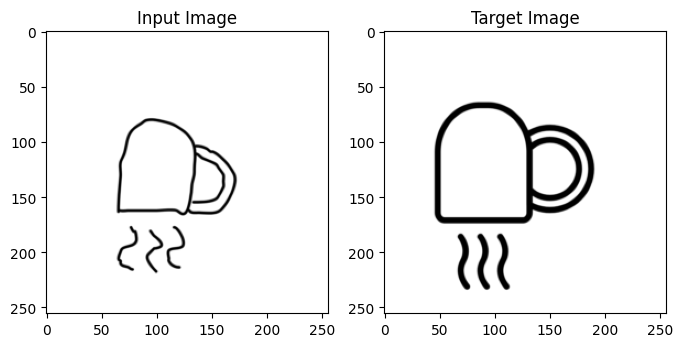

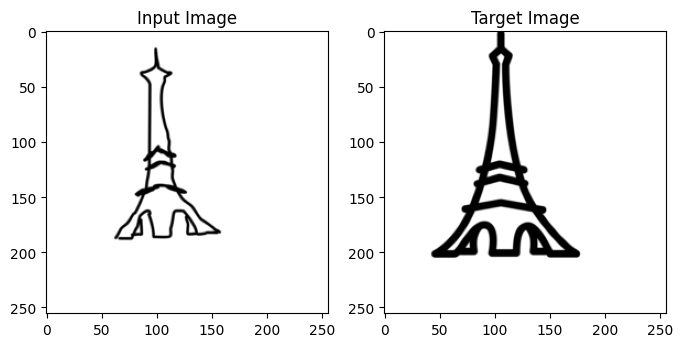

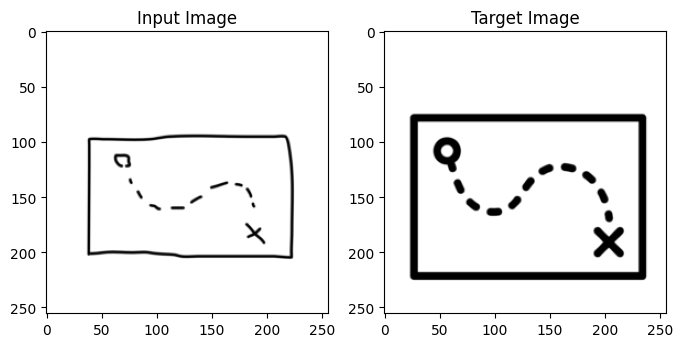

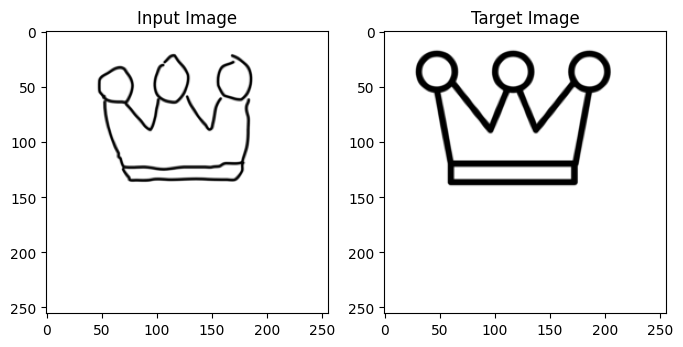

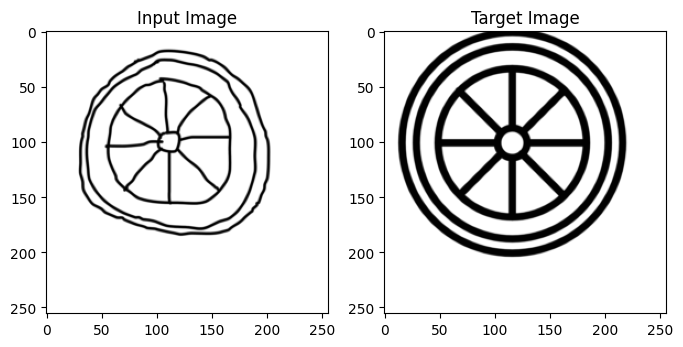

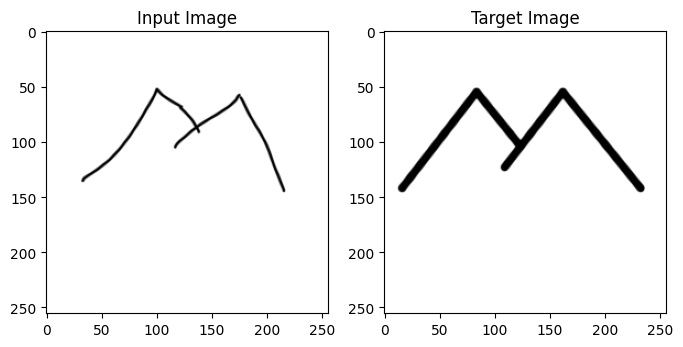

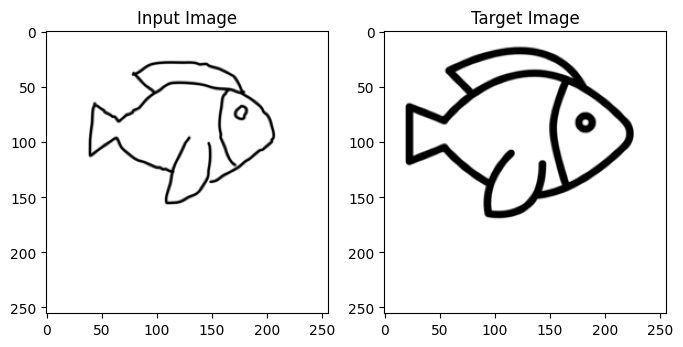

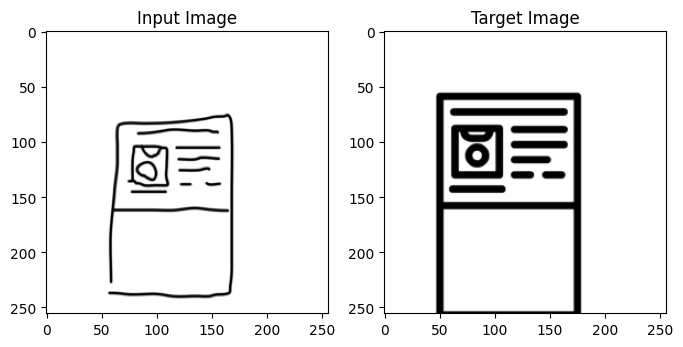

In [ ]:
for j, [image, target] in enumerate(train_loader):
  for k in range(batch_size):
    input_image = image[k].permute(1, 2, 0).numpy()
    target_image = target[k].permute(1, 2, 0).numpy()

    plt.figure(figsize=(8, 4))

    plt.subplot(1, 2, 1)
    plt.imshow(input_image, cmap='gray')
    plt.title("Input Image")

    plt.subplot(1, 2, 2)
    plt.imshow(target_image, cmap='gray')
    plt.title("Target Image")

    plt.show()
  break

## 5. Train

In [ ]:
loss_list = []

for i in range(num_epoch):
    for j, [image, target] in enumerate(train_loader):
        optimizer.zero_grad()
        image = image.to(device)
        target = target.to(device)
        output = model(image)

        loss = loss_func(output, target)
        loss.backward()
        optimizer.step()


    loss_list.append(loss.item())#loss값을 저장한다
    print(i, " epoch: ",loss)

0  epoch:  tensor(0.4595, device='cuda:0', grad_fn=<MseLossBackward0>)
1  epoch:  tensor(0.2015, device='cuda:0', grad_fn=<MseLossBackward0>)
2  epoch:  tensor(0.0789, device='cuda:0', grad_fn=<MseLossBackward0>)
3  epoch:  tensor(0.0514, device='cuda:0', grad_fn=<MseLossBackward0>)
4  epoch:  tensor(0.0484, device='cuda:0', grad_fn=<MseLossBackward0>)
5  epoch:  tensor(0.0498, device='cuda:0', grad_fn=<MseLossBackward0>)
6  epoch:  tensor(0.0449, device='cuda:0', grad_fn=<MseLossBackward0>)
7  epoch:  tensor(0.0396, device='cuda:0', grad_fn=<MseLossBackward0>)
8  epoch:  tensor(0.0370, device='cuda:0', grad_fn=<MseLossBackward0>)
9  epoch:  tensor(0.0363, device='cuda:0', grad_fn=<MseLossBackward0>)
10  epoch:  tensor(0.0386, device='cuda:0', grad_fn=<MseLossBackward0>)
11  epoch:  tensor(0.0304, device='cuda:0', grad_fn=<MseLossBackward0>)
12  epoch:  tensor(0.0355, device='cuda:0', grad_fn=<MseLossBackward0>)
13  epoch:  tensor(0.0347, device='cuda:0', grad_fn=<MseLossBackward0>)
14

## 6. Check with Train Image

torch.Size([8, 256, 256])
(8, 256, 256)


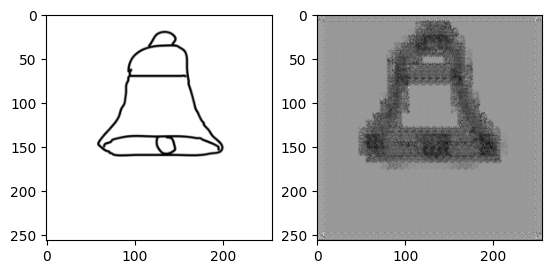

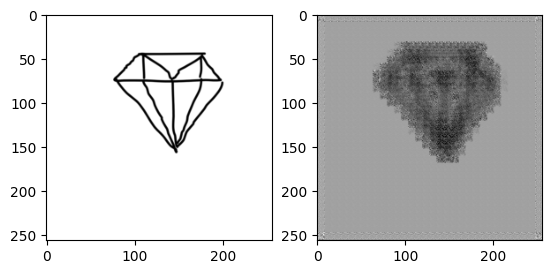

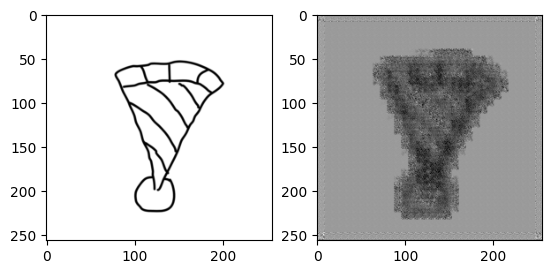

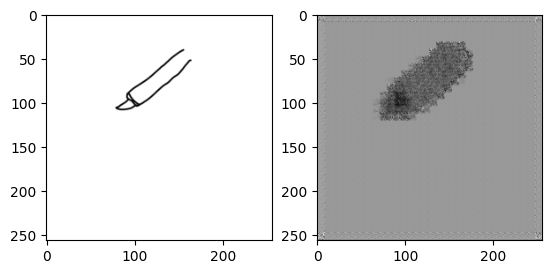

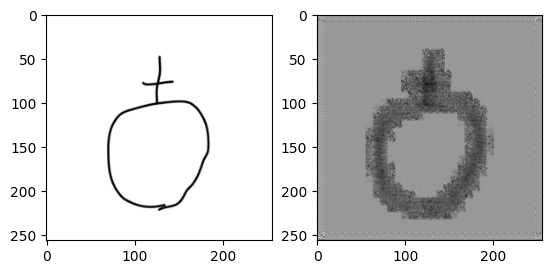

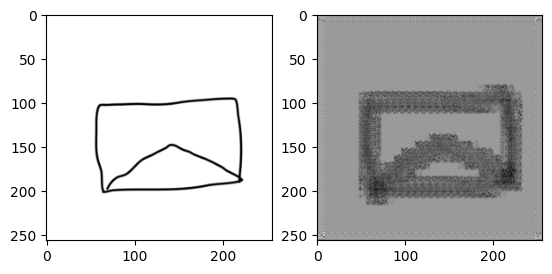

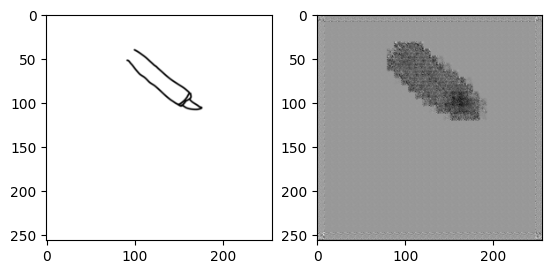

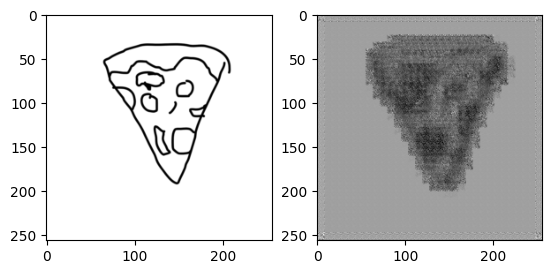

In [ ]:
out_img = torch.squeeze(output.cpu().data)
print(out_img.size())
print(torch.squeeze(image).cpu().numpy().shape)
for i in range(8):
    plt.subplot(1,2,1)
    plt.imshow(torch.squeeze(image[i]).cpu().numpy(),cmap='gray')
    plt.subplot(1,2,2)
    plt.imshow(out_img[i].numpy(),cmap='gray')
    plt.show()

## 7. Test

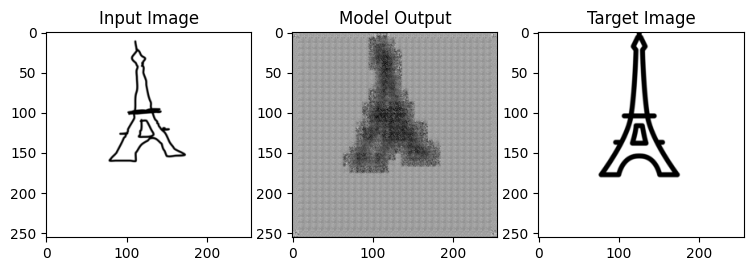

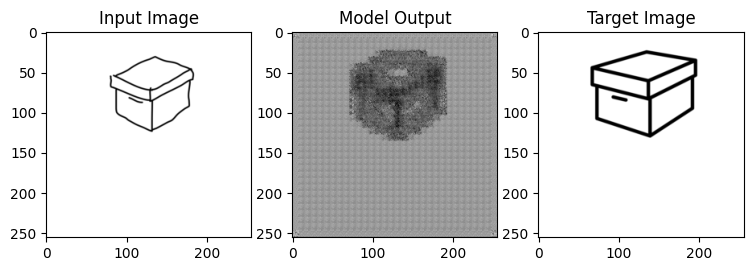

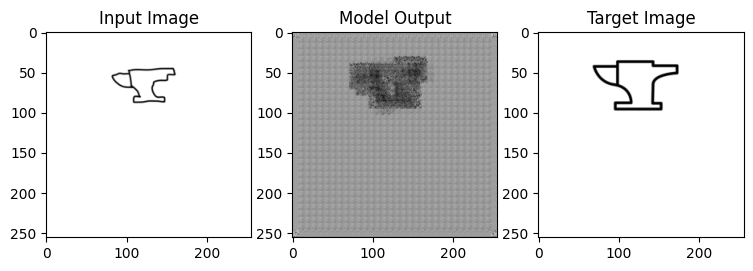

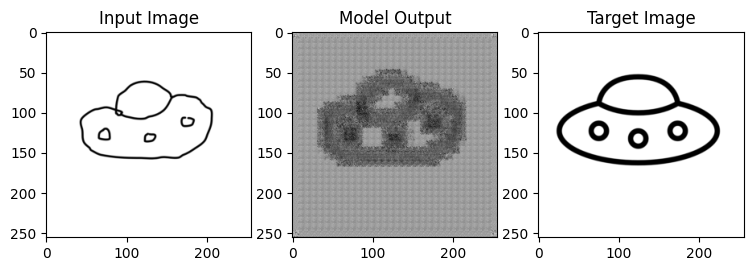

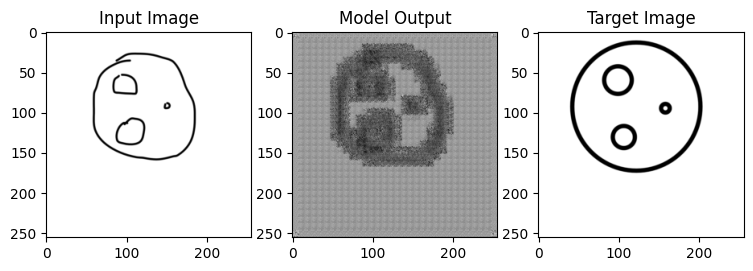

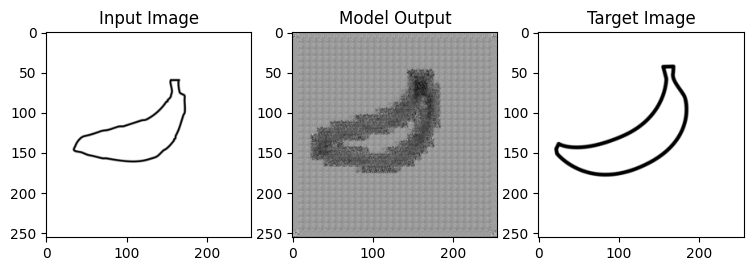

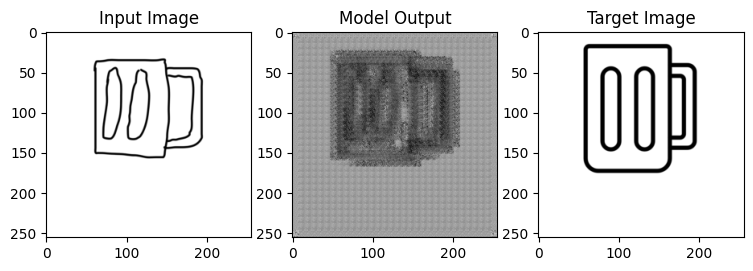

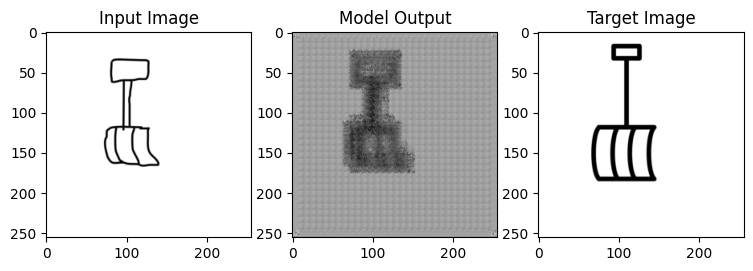

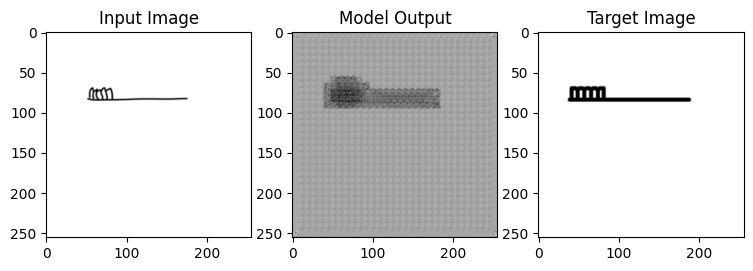

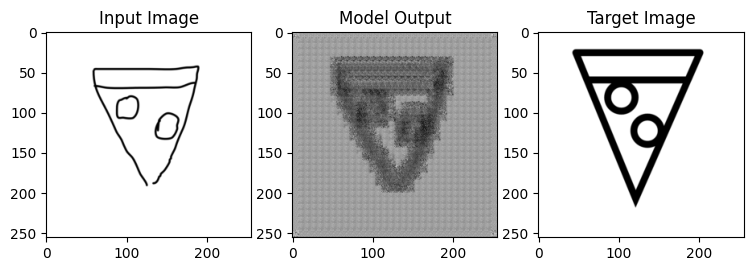

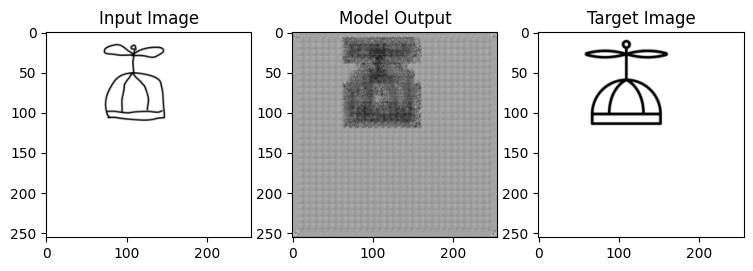

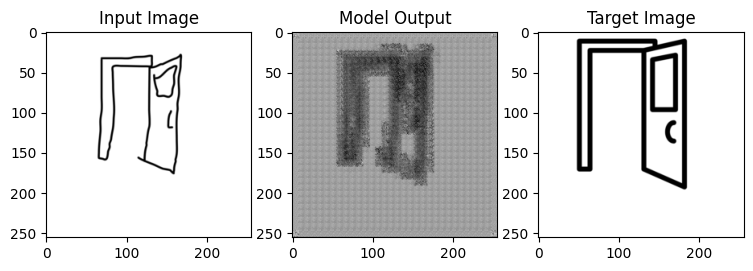

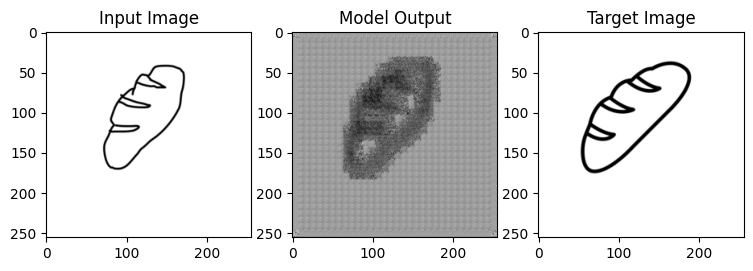

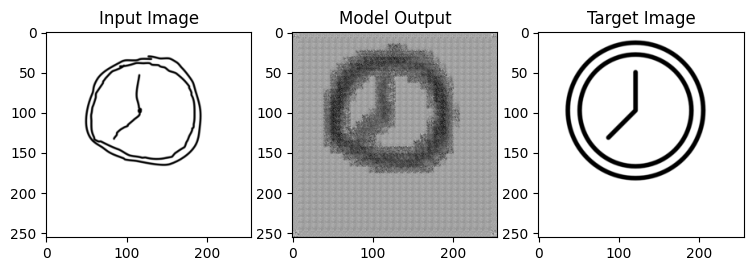

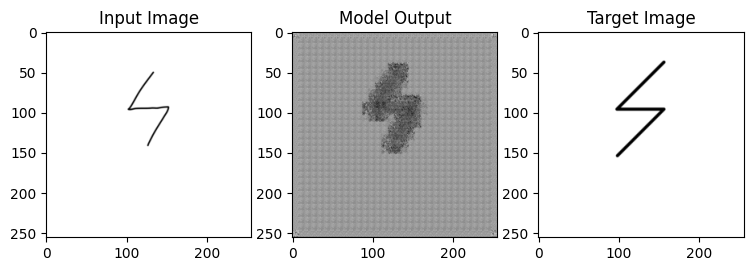

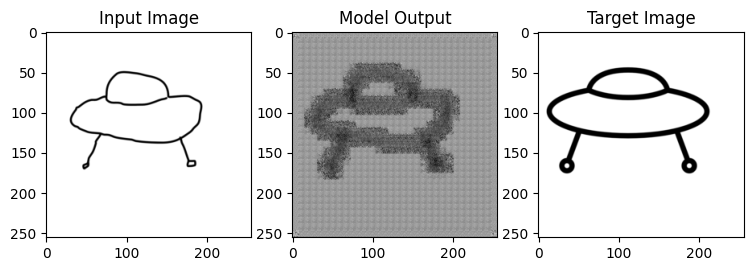

Test Loss: 0.0354


In [ ]:
model.eval()  # 모델을 평가 모드로 설정
test_loss = 0

with torch.no_grad():  # 그래디언트 계산을 비활성화
    for image, target in test_loader:
        image = image.to(device)
        target = target.to(device)

        output = model(image)
        loss = loss_func(output, target)
        test_loss += loss.item()  # 누적 테스트 손실

        output_np = output.cpu().numpy()
        image_np = image.cpu().numpy()
        target_np = target.cpu().numpy()

        for i in range(8):
            plt.figure(figsize=(9, 3))  # 이미지 크기 조정

            # 원본 이미지
            plt.subplot(1, 3, 1)
            plt.imshow(np.squeeze(image_np[i]), cmap='gray')
            plt.title("Input Image")

            # 모델 적용 이미지
            plt.subplot(1, 3, 2)
            plt.imshow(np.squeeze(output_np[i]), cmap='gray')
            plt.title("Model Output")

            # 타겟 이미지
            plt.subplot(1, 3, 3)
            plt.imshow(np.squeeze(target_np[i]), cmap='gray')
            plt.title("Target Image")

            plt.show()

    test_loss /= len(test_loader)  # 평균 테스트 손실 계산

print(f"Test Loss: {test_loss:.4f}")

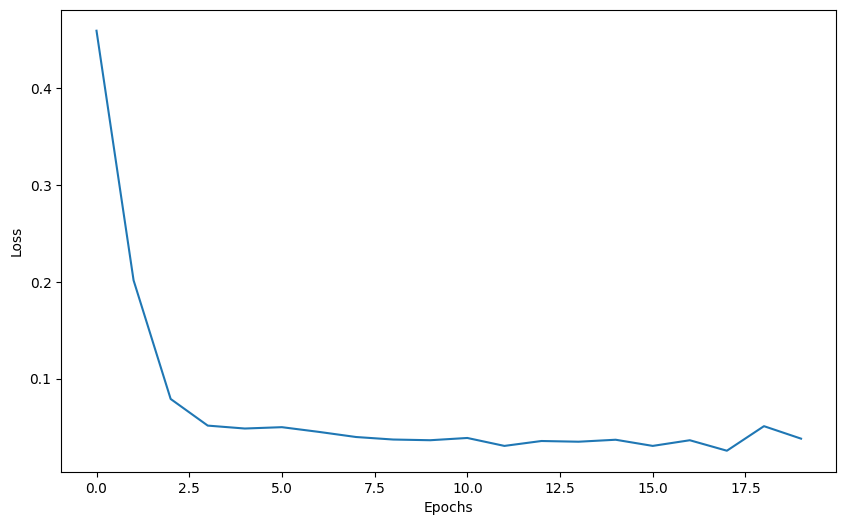

In [ ]:
#loss값을 기록해서 그래프로 그리기
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 6))
plt.plot(loss_list)
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.show()